In [2]:
import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Add the directory containing preprocessor.py to the Python path
script_dir = r"C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles"
sys.path.append(script_dir)

# Import the preprocessor module
import preprocessor

# Define base file path
base_path = r"C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data"
timeframes = ["1", "5", "15", "30", "60", "240", "720", "1440"]

# Process each timeframe and output to the appropriate folder
for timeframe in timeframes:
    input_filepath = os.path.join(base_path, f"{timeframe}min", f"XBTUSD_{timeframe}.csv")
    output_dir = os.path.join(base_path, f"{timeframe}min")
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    output_filepath = os.path.join(output_dir, f"XBTUSD_{timeframe}_with_features.csv")
    preprocessor.process_file(input_filepath, output_filepath)

Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\1min\XBTUSD_1_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\5min\XBTUSD_5_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\15min\XBTUSD_15_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\30min\XBTUSD_30_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\60min\XBTUSD_60_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\240min\XBTUSD_240_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\720min\XBTUSD_720_with_features.csv
Processed file saved to: C:\Users\abrau\uvic\seng474\project\CryptoAI\AndrewFiles\XBTUSD Data\1440min\XB

In [12]:
# Initialize dictionaries to store MAE values for each timeframe
final_train_mae = {}
final_test_mae = {}

# Train model for each timeframe
# First determine max_samples from 1440min data
max_samples = None
try:
    # Load 1440min data to determine max_samples
    ref_filepath = os.path.join(base_path, "1440min", "XBTUSD_1440_with_features.csv")
    ref_df = pd.read_csv(ref_filepath).drop(columns=['Timestamp'])
    ref_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    ref_df.dropna(inplace=True)
    max_samples = len(ref_df)
    print(f"Setting max_samples to {max_samples} based on 1440min data")
except Exception as e:
    print(f"Could not determine max_samples from 1440min data: {e}")
    max_samples = None

for timeframe in timeframes:
    train_filepath = os.path.join(base_path, f"{timeframe}min", f"XBTUSD_{timeframe}_with_features.csv")
    if not os.path.exists(train_filepath):
        print(f"Skipping {timeframe}min as file does not exist.")
        continue
    
    # Load and preprocess training data
    train_df = pd.read_csv(train_filepath).drop(columns=['Timestamp'])
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)
    
    # Use only the most recent max_samples data points if max_samples is set
    if max_samples is not None:
        train_df = train_df.tail(max_samples)
    
    train_data = train_df.values

    # Normalize data
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)

    # Create sequences for LSTM
    sequence_length = 50
    X, y = [], []
    for i in range(len(train_data_scaled) - sequence_length):
        X.append(train_data_scaled[i:i+sequence_length])
        y.append(train_data_scaled[i+sequence_length, 3])  # Predict closing price
    X, y = np.array(X), np.array(y)

    # Split into 80% train and 20% test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Further split train into 80% train and 20% validation
    val_split_idx = int(len(X_train) * 0.8)
    X_train_final, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
    y_train_final, y_val = y_train[:val_split_idx], y_train[val_split_idx:]

    print(f"\nTraining {timeframe}min with {len(X_train_final)} train, {len(X_val)} validation, and {len(X_test)} test samples")

    # Define LSTM model
    model = Sequential([
        LSTM(units=256, return_sequences=True, input_shape=(sequence_length, train_data.shape[1])),
        Dropout(0.2),
        LSTM(units=128, return_sequences=False),
        Dropout(0.2),
        Dense(256, activation='tanh'),
        Dropout(0.2),
        Dense(128, activation='tanh'),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train model with validation data
    history = model.fit(
        X_train_final, 
        y_train_final, 
        epochs=20, 
        batch_size=32, 
        validation_data=(X_val, y_val), 
        callbacks=[early_stopping], 
        verbose=1
    )

    # Make sure we're storing a single float value, not a list
    final_train_mae[timeframe] = float(history.history['mae'][-1])
    
    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    final_test_mae[timeframe] = float(test_mae)
    
    # Print training metrics
    print(f"\nMetrics for {timeframe}min timeframe:")
    print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

Setting max_samples to 3950 based on 1440min data

Training 1min with 2496 train, 624 validation, and 780 test samples
Epoch 1/20
78/78 [==============================] - 34s 378ms/step - loss: 0.0251 - mae: 0.1048 - val_loss: 0.0312 - val_mae: 0.1653
Epoch 2/20
78/78 [==============================] - 33s 417ms/step - loss: 0.0095 - mae: 0.0775 - val_loss: 0.0306 - val_mae: 0.1627
Epoch 3/20
78/78 [==============================] - 31s 401ms/step - loss: 0.0074 - mae: 0.0688 - val_loss: 0.0295 - val_mae: 0.1588
Epoch 4/20
78/78 [==============================] - 33s 420ms/step - loss: 0.0061 - mae: 0.0621 - val_loss: 0.0314 - val_mae: 0.1645
Epoch 5/20
78/78 [==============================] - 32s 411ms/step - loss: 0.0057 - mae: 0.0600 - val_loss: 0.0313 - val_mae: 0.1634
Epoch 6/20
78/78 [==============================] - 31s 403ms/step - loss: 0.0052 - mae: 0.0573 - val_loss: 0.0391 - val_mae: 0.1859
Epoch 7/20
78/78 [==============================] - 31s 402ms/step - loss: 0.0046 -

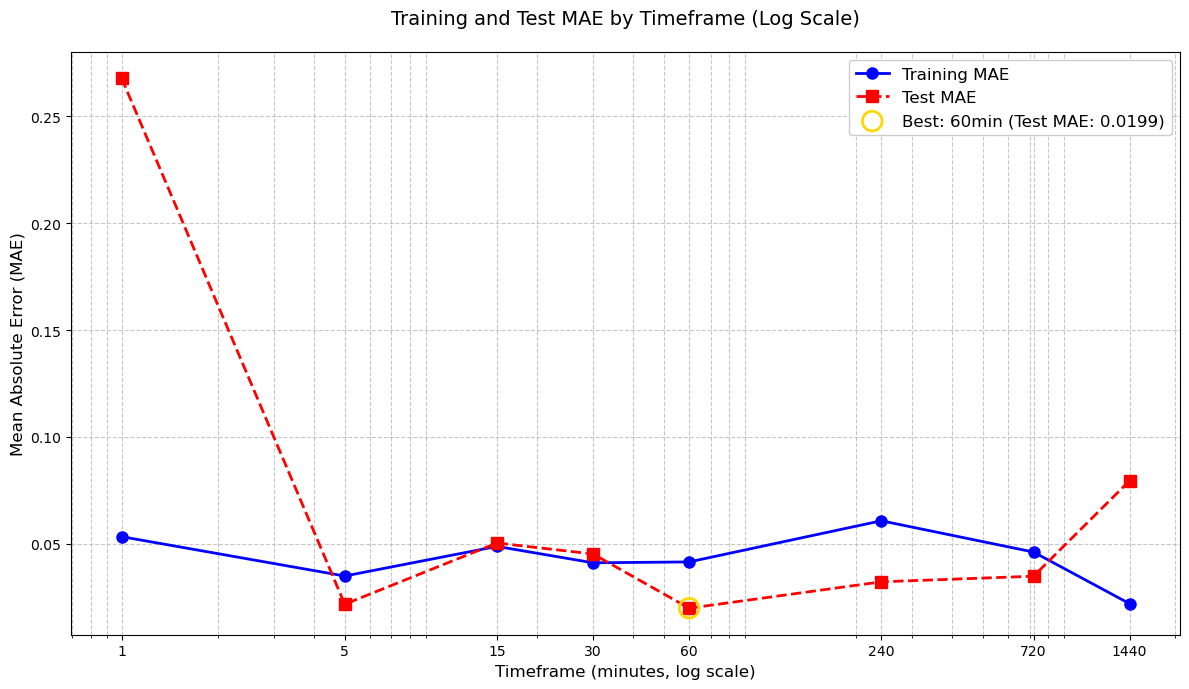


=== BEST PERFORMING TIMEFRAME ===
Timeframe: 60 minutes
Training MAE: 0.041525
Test MAE: 0.019865
Difference: 0.021660


In [25]:
# After training all timeframes, plot the results
import matplotlib.pyplot as plt
import numpy as np

# Sort timeframes numerically for consistent plotting
sorted_timeframes = sorted(final_train_mae.keys(), key=lambda x: int(x))

# Convert to numeric values for log scale
timeframe_nums = np.array([int(tf) for tf in sorted_timeframes])

# Get MAE values in the same order
train_mae_values = [final_train_mae[tf] for tf in sorted_timeframes]
test_mae_values = [final_test_mae[tf] for tf in sorted_timeframes]

# Find the best performing timeframe (lowest test MAE)
best_idx = np.argmin(test_mae_values)
best_timeframe = sorted_timeframes[best_idx]
best_train_mae = train_mae_values[best_idx]
best_test_mae = test_mae_values[best_idx]

# Create the plot with log scale x-axis
plt.figure(figsize=(12, 7))
plt.semilogx(timeframe_nums, train_mae_values, 'b-o', linewidth=2, markersize=8, label='Training MAE')
plt.semilogx(timeframe_nums, test_mae_values, 'r--s', linewidth=2, markersize=8, label='Test MAE')

# Highlight the best performing timeframe
plt.scatter(timeframe_nums[best_idx], test_mae_values[best_idx], 
            s=200, facecolors='none', edgecolors='gold', 
            linewidths=2, zorder=10,
            label=f'Best: {best_timeframe}min (Test MAE: {best_test_mae:.4f})')

# Add labels and title with enhanced formatting
plt.title('Training and Test MAE by Timeframe (Log Scale)', fontsize=14, pad=20)
plt.xlabel('Timeframe (minutes, log scale)', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

# Set custom x-ticks to show all timeframes clearly
plt.xticks(timeframe_nums, labels=sorted_timeframes)
plt.gca().xaxis.grid(True, which='both')  # Add grid lines for all timeframes

# Add legend and grid
plt.legend(fontsize=12, framealpha=1)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Adjust layout and show
plt.tight_layout()
plt.savefig('mae_vs_timeframe_logscale_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the best performing timeframe and its MAE values
print("\n=== BEST PERFORMING TIMEFRAME ===")
print(f"Timeframe: {best_timeframe} minutes")
print(f"Training MAE: {best_train_mae:.6f}")
print(f"Test MAE: {best_test_mae:.6f}")
print(f"Difference: {abs(best_train_mae - best_test_mae):.6f}")

In [15]:
# Find the timeframe with the lowest test MAE
best_timeframe = min(final_test_mae, key=final_test_mae.get)
best_mae = final_test_mae[best_timeframe]
print(f"\nBest timeframe: {best_timeframe}min with test MAE: {best_mae:.4f}")

# Now retrain a model on the best timeframe's data
print(f"\nRetraining model on best timeframe: {best_timeframe}min")

# Load and preprocess the best timeframe's data
best_filepath = os.path.join(base_path, f"{best_timeframe}min", f"XBTUSD_{best_timeframe}_with_features.csv")
best_df = pd.read_csv(best_filepath).drop(columns=['Timestamp'])
best_df.replace([np.inf, -np.inf], np.nan, inplace=True)
best_df.dropna(inplace=True)

# Use only the most recent max_samples data points if max_samples is set
#if max_samples is not None:
    #best_df = best_df.tail(max_samples)

best_data = best_df.values

# Normalize data
scaler = MinMaxScaler()
best_data_scaled = scaler.fit_transform(best_data)

# Create sequences for LSTM
sequence_length = 50
X, y = [], []
for i in range(len(best_data_scaled) - sequence_length):
    X.append(best_data_scaled[i:i+sequence_length])
    y.append(best_data_scaled[i+sequence_length, 3])  # Predict closing price
X, y = np.array(X), np.array(y)

# Split into 80% train and 20% test
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Further split train into 80% train and 20% validation
val_split_idx = int(len(X_train) * 0.8)
X_train_final, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
y_train_final, y_val = y_train[:val_split_idx], y_train[val_split_idx:]

print(f"\nRetraining {best_timeframe}min with {len(X_train_final)} train, {len(X_val)} validation, and {len(X_test)} test samples")

# Define LSTM model (you can adjust architecture if needed)
model = Sequential([
    LSTM(units=256, return_sequences=True, input_shape=(sequence_length, best_data.shape[1])),
    Dropout(0.2),
    LSTM(units=128, return_sequences=False),
    Dropout(0.2),
    Dense(256, activation='tanh'),
    Dropout(0.2),
    Dense(128, activation='tanh'),
    Dense(1)
])

# Compile model
model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with validation data
history = model.fit(
    X_train_final, 
    y_train_final, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping], 
    verbose=1
)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Print final metrics
print(f"\nFinal Metrics for retrained {best_timeframe}min model:")
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# You might want to save this best model
model.save(f'best_model_{best_timeframe}min.h5')
print(f"Saved best model as 'best_model_{best_timeframe}min.h5'")


Best timeframe: 60min with test MAE: 0.0199

Retraining model on best timeframe: 60min

Retraining 60min with 54605 train, 13652 validation, and 17065 test samples
Epoch 1/20
1707/1707 [==============================] - 899s 525ms/step - loss: 0.0023 - mae: 0.0312 - val_loss: 4.6913e-04 - val_mae: 0.0150
Epoch 2/20
1707/1707 [==============================] - 885s 518ms/step - loss: 8.2884e-04 - mae: 0.0212 - val_loss: 3.5049e-04 - val_mae: 0.0131
Epoch 3/20
1707/1707 [==============================] - 867s 508ms/step - loss: 6.5577e-04 - mae: 0.0188 - val_loss: 3.7036e-04 - val_mae: 0.0132
Epoch 4/20
1707/1707 [==============================] - 855s 501ms/step - loss: 5.7438e-04 - mae: 0.0174 - val_loss: 3.0894e-04 - val_mae: 0.0123
Epoch 5/20
1707/1707 [==============================] - 897s 526ms/step - loss: 5.0896e-04 - mae: 0.0163 - val_loss: 3.0840e-04 - val_mae: 0.0121
Epoch 6/20
1707/1707 [==============================] - 874s 512ms/step - loss: 4.7387e-04 - mae: 0.0155 - va

C:\Users\abrau\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved best model as 'best_model_60min.h5'


In [22]:
import matplotlib.pyplot as plt

# Hyperparameter configuration
SEQUENCE_LENGTHS = [5, 10, 20, 30, 50, 75, 100]  # Different history windows to test
DATA_PERCENTAGE = 1.0  # Use 100% of data for faster tuning

# Load and prepare data
best_filepath = os.path.join(base_path, f"{best_timeframe}min", f"XBTUSD_{best_timeframe}_with_features.csv")
best_df = pd.read_csv(best_filepath).drop(columns=['Timestamp'])
best_df.replace([np.inf, -np.inf], np.nan, inplace=True)
best_df.dropna(inplace=True)

# Use only a percentage of the data for tuning
best_df = best_df.iloc[:int(len(best_df) * DATA_PERCENTAGE)]
best_data = best_df.values
scaler = MinMaxScaler()
best_data_scaled = scaler.fit_transform(best_data)

# Results storage
results = {
    'sequence_lengths': [],
    'train_mae': [],
    'val_mae': [],
    'test_mae': []
}

# Hyperparameter tuning loop
for seq_len in SEQUENCE_LENGTHS:
    print(f"\n=== Training with sequence length: {seq_len} ===")
    
    # Create sequences
    X, y = [], []
    for i in range(len(best_data_scaled) - seq_len):
        X.append(best_data_scaled[i:i+seq_len])
        y.append(best_data_scaled[i+seq_len, 3])  # Closing price
    X, y = np.array(X), np.array(y)

    # Split data (60% train, 20% val, 20% test)
    train_size = int(0.6 * len(X))
    val_size = int(0.2 * len(X))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

    # Define model (same architecture each time)
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=(seq_len, best_data.shape[1])),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(256, activation='tanh'),
        Dropout(0.2),
        Dense(128, activation='tanh'),
        Dense(1)
    ])
    
    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    
    # Train with early stopping
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
        verbose=1
    )
    
    # Evaluate
    _, train_mae = model.evaluate(X_train, y_train, verbose=0)
    _, val_mae = model.evaluate(X_val, y_val, verbose=0)
    _, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Store results
    results['sequence_lengths'].append(seq_len)
    results['train_mae'].append(train_mae)
    results['val_mae'].append(val_mae)
    results['test_mae'].append(test_mae)
    
    print(f"Seq Len {seq_len} Results:")
    print(f"Train MAE: {train_mae:.6f}")
    print(f"Val MAE: {val_mae:.6f}")
    print(f"Test MAE: {test_mae:.6f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(results['sequence_lengths'], results['train_mae'], 'bo-', label='Train MAE')
plt.plot(results['sequence_lengths'], results['val_mae'], 'go-', label='Validation MAE')
plt.plot(results['sequence_lengths'], results['test_mae'], 'ro-', label='Test MAE')

plt.title(f'MAE vs Sequence Length ({best_timeframe}min timeframe)')
plt.xlabel('Sequence Length (time steps)')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Annotate the best validation MAE
best_idx = np.argmin(results['val_mae'])
best_seq = results['sequence_lengths'][best_idx]
best_mae = results['val_mae'][best_idx]
plt.annotate(f'Best: {best_seq} steps\nMAE: {best_mae:.4f}',
             xy=(best_seq, best_mae),
             xytext=(best_seq+10, best_mae+0.005),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.xticks(SEQUENCE_LENGTHS)
plt.tight_layout()
plt.savefig(f'sequence_length_tuning_{best_timeframe}min.png')
plt.show()

print("\n=== Summary ===")
print(f"Best sequence length: {best_seq}")
print(f"Validation MAE at best length: {best_mae:.6f}")
print(f"Corresponding Test MAE: {results['test_mae'][best_idx]:.6f}")


=== Training with sequence length: 5 ===
Epoch 1/20
1601/1601 [==============================] - 210s 127ms/step - loss: 0.0022 - mae: 0.0380 - val_loss: 0.0799 - val_mae: 0.2568
Epoch 2/20
1601/1601 [==============================] - 196s 123ms/step - loss: 7.3486e-04 - mae: 0.0210 - val_loss: 0.0360 - val_mae: 0.1685
Epoch 3/20
1601/1601 [==============================] - 196s 123ms/step - loss: 4.9723e-04 - mae: 0.0173 - val_loss: 0.0233 - val_mae: 0.1335
Epoch 4/20
1601/1601 [==============================] - 196s 123ms/step - loss: 4.1990e-04 - mae: 0.0159 - val_loss: 0.0183 - val_mae: 0.1177
Epoch 5/20
1601/1601 [==============================] - 196s 123ms/step - loss: 3.7603e-04 - mae: 0.0151 - val_loss: 0.0150 - val_mae: 0.1061
Epoch 6/20
1601/1601 [==============================] - 196s 123ms/step - loss: 3.3104e-04 - mae: 0.0142 - val_loss: 0.0121 - val_mae: 0.0949
Epoch 7/20
1601/1601 [==============================] - 196s 122ms/step - loss: 3.0348e-04 - mae: 0.0136 - val

KeyboardInterrupt: 